# Time Series Analysis

### Content:
- Sourcing Time Series Data
- Wrangling/Subsetting
- Cleaning
- Time Series Analysis
- Test for Stationarity
- Check for Autocorrelations
- Differencing

In [1]:
#import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

#disable deprecation warnings
warnings.filterwarnings('ignore')

#styling option for plots
plt.style.use('fivethirtyeight')

### Sourcing Time Series Data

In [2]:
#configure API key
quandl.ApiConfig.api_key = '7LscxsFxQxC8ESTtresh'

In [3]:
#import Energy Production and Consumption data --> Crude Oil Prices from 1861
data = quandl.get('BP/CRUDE_OIL_PRICES')

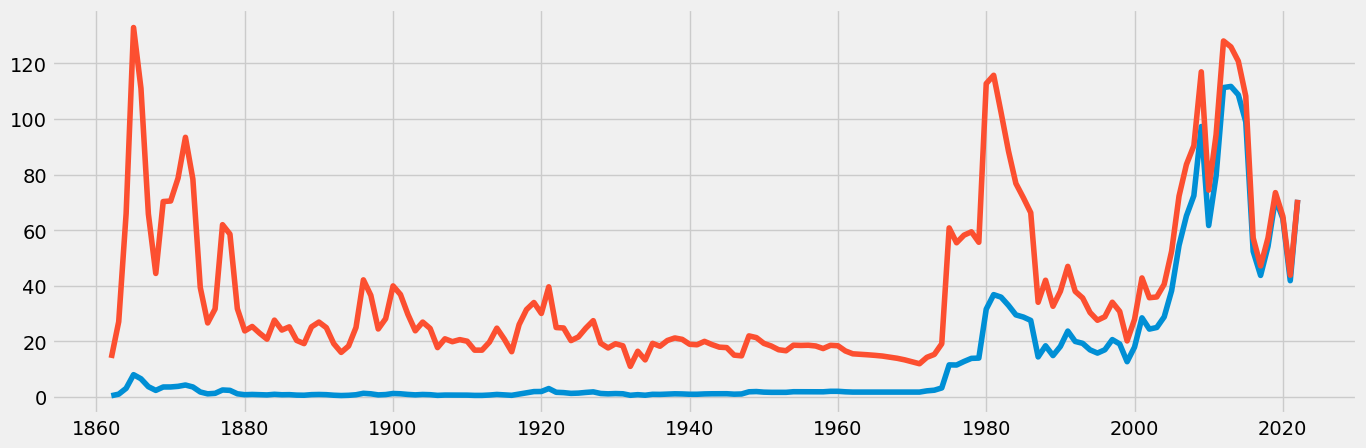

In [4]:
#create a line chart of your data
plt.figure(figsize = (15,5), dpi=100)
plt.plot(data)

- Red line: Price/Barrel in 2021 Dollars (adjusted for inflation)
- Blue Line: Price/Barrel in Contemporary Dollars



### Wrangling/Subsetting

In [5]:
#create a subset of the data dating back only to 1970
data_2 = data.reset_index()

In [6]:
data_2.head()

,Date,Price in Contemporary Dollars,Price in 2021 Dollars
0,1861-12-31,0.49,14.057327
1,1862-12-31,1.05,27.110560
2,1863-12-31,3.15,65.944605
3,1864-12-31,8.06,132.833502
4,1865-12-31,6.59,110.968067


In [7]:
data_2['Date'].value_counts()

1861-12-31    1
1942-12-31    1
1964-12-31    1
1965-12-31    1
1966-12-31    1
             ..
1916-12-31    1
1917-12-31    1
1918-12-31    1
1919-12-31    1
2021-12-31    1
Name: Date, Length: 161, dtype: int64

This is annual data collected on the last day of the year.

In [8]:
data_sub = data_2.loc[data_2['Date'] >= '1970-12-31']

In [9]:
data_sub.shape

(52, 3)

In [10]:
data_sub.head()

,Date,Price in Contemporary Dollars,Price in 2021 Dollars
109,1970-12-31,1.80,11.991231
110,1971-12-31,2.24,14.296306
111,1972-12-31,2.48,15.346664
112,1973-12-31,3.29,19.166999
113,1974-12-31,11.58,60.809767


In [11]:
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime')
data_sub = data_sub.drop(columns = ['Date'])
data_sub.head()

,Price in Contemporary Dollars,Price in 2021 Dollars
datetime,,
1970-12-31,1.80,11.991231
1971-12-31,2.24,14.296306
1972-12-31,2.48,15.346664
1973-12-31,3.29,19.166999
1974-12-31,11.58,60.809767


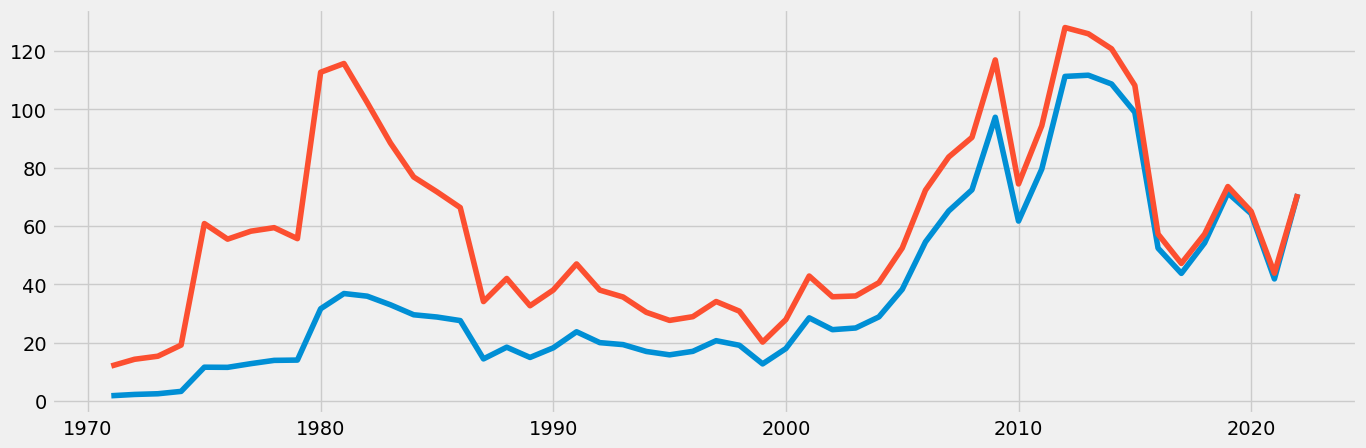

In [12]:
#plot the subset
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

The oil prices saw a spike toward the end of the 70's when OPEC imposed an embargo on the U.S., creating a shortage of petroleum(crude oil). We should be careful in allowing this in our forecast as it can bias results, but prices have still fluctuated significantly in the most recent 15 years. We'll keep it in there for now and see what happens.

### Data Cleaning

In [13]:
#check for missing values
data_sub.isnull().sum() 

Price in Contemporary Dollars    0
Price in 2021 Dollars            0
dtype: int64

In [14]:
#check for duplicates
dups = data_sub.duplicated()
dups.sum()

0

### Time Series Analysis

In [15]:
#decomposition for 2020 dollars
decomposition = sm.tsa.seasonal_decompose(data_sub['Price in 2021 Dollars'], model='additive')

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

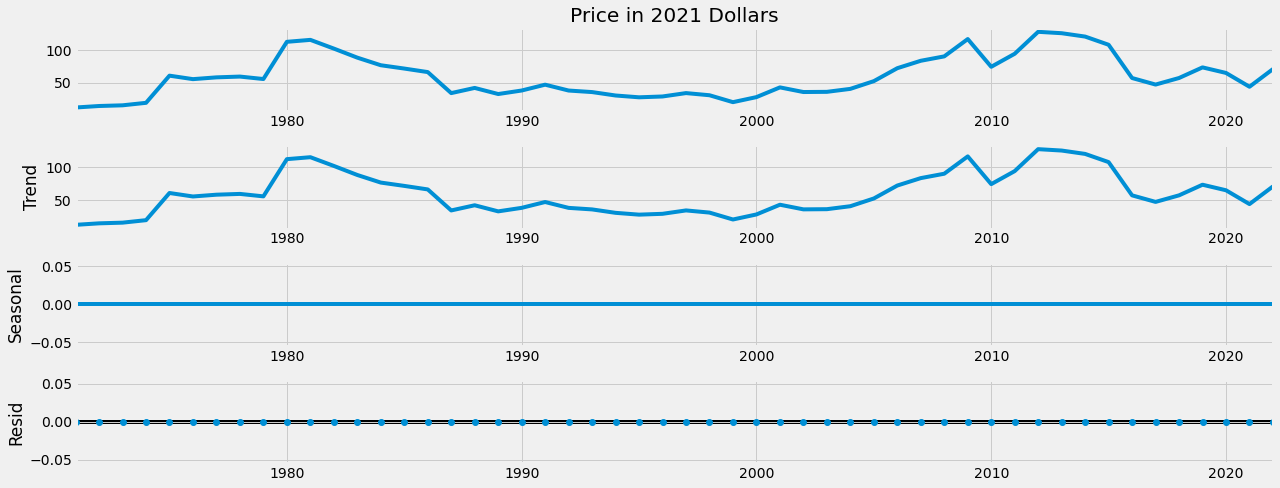

In [17]:
decomposition.plot()
plt.show()

We don't have any seasonality or noise in our data, just a general trend. This is because our data is on an annual basis. There are a couple cycles; increasing until about 1981, decreasing until 1999, increasing until 2012, and decreasing since.

### Test for Stationarity

In [18]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data_sub['Price in 2021 Dollars'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.385313
p-value                         0.145925
Number of Lags Used             0.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


Our test statistic is greater than the critical value for the 10% significance level, meaning that the probability of a unit root being present in our data is greater than 10%, and that we can't disprove non-stationarity. 

### Check for Autocorrelations

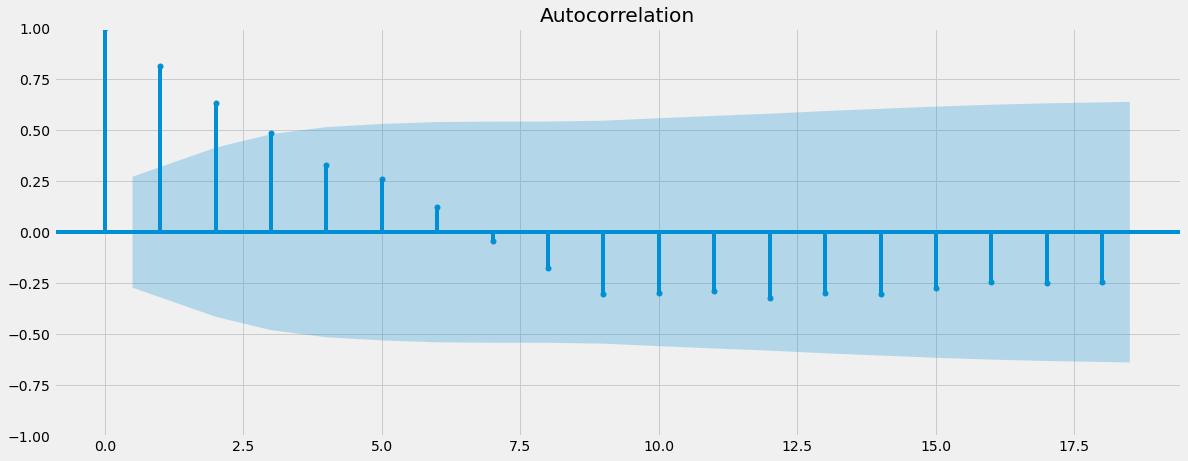

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub['Price in 2021 Dollars'])
plt.show()

Most of our data is not autocorrelated. The first four are outside the blue area/confidence interval are significantly correlated, which we can improve since we need to make our data stationary.

### Differencing

In [20]:
#stationarize the data using a differencing technique
data_diff = data_sub - data_sub.shift(1)

In [21]:
#remove the NaN created as the first observation
data_diff.dropna(inplace=True)

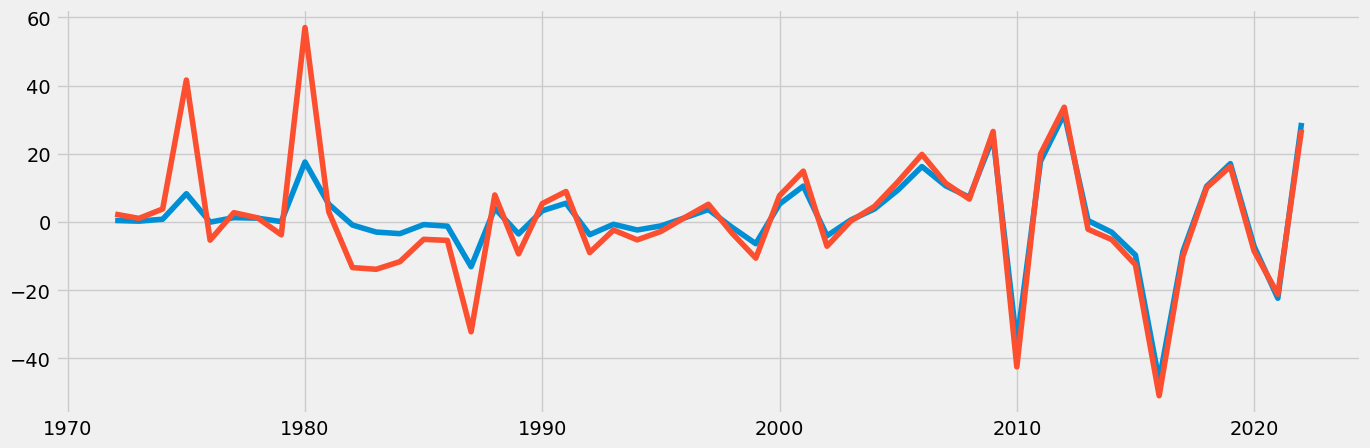

In [22]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

This is what our data looks like detrended. Let's run the Dickey-Fuller test and autocorrelation check again.

In [23]:
def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data_diff['Price in 2021 Dollars'])

Dickey-Fuller Stationarity test:
Test Statistic                -6.721813e+00
p-value                        3.467782e-09
Number of Lags Used            0.000000e+00
Number of Observations Used    5.000000e+01
Critical Value (1%)           -3.568486e+00
Critical Value (5%)           -2.921360e+00
Critical Value (10%)          -2.598662e+00
dtype: float64


The test statistic is now much lower than the 1% critical value, meaning there's a less than 1% chance that a unit root exists now. Our data is stationary. 

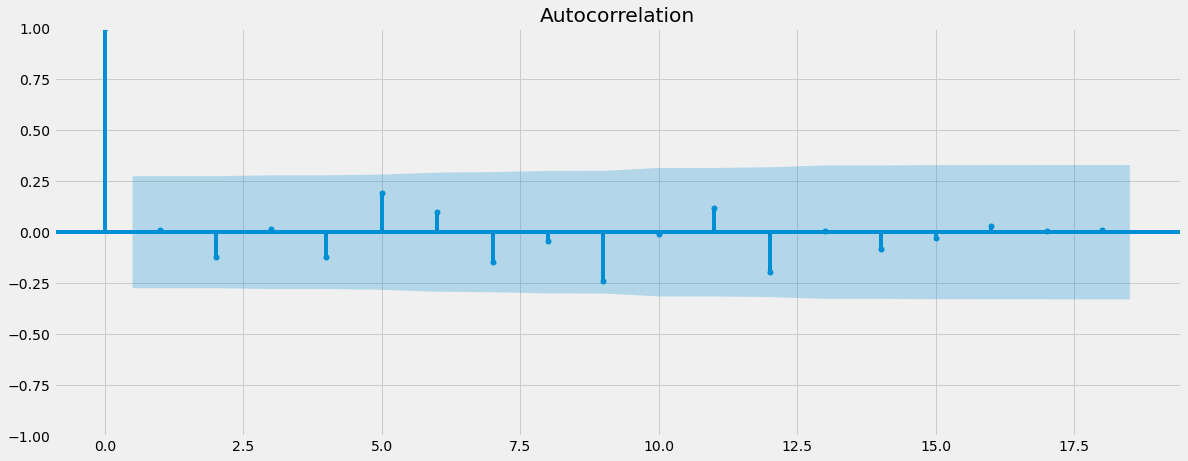

In [24]:
plot_acf(data_diff['Price in 2021 Dollars'])
plt.show()

Only the first lag has a significant correlation. Much better.

In [26]:
#export the differenced dataframe
data_diff.to_pickle('/Users/kimballwightman/Desktop/Projects/Oil Prices Time Series Forecast/01 Data/data_diff.pkl')